# Introduction

A key feature of PorePy is that forward-mode automatic (or algorithmic) differentiation, AD, is used to linearize a system of partial differential equations. This tutorial provides an introduction to how the AD in embedded into the PorePy model.

The time stepping algorithm at the core of PorePy involves numerically solving a discretized system of PDEs $F$ with respect to the vector of variables $x$. Most numerical solution algorithms rely on computing the Jacobian matrix of this system: $J:=\dfrac{\partial F}{\partial x}$. However, programming a formula to compute the Jacobian matrix can be difficult, as it requires analytic differentiation of the equation $F$.

Fortunately, the PorePy model developers do not need to perform this task, as the AD framework handles it for them. In this tutorial, we will first learn some basics about the AD framework.

# AD basics

The core of the AD framework is the `AdArray` class. It contains 2 attributes:
- `val` - the value of the variable it represents.
- `jac` - the Jacobian matrix of the variable it represents.

Let's create an independent variable - the vector `x = [1, 2, 3]`.
As the variable is independent, its Jacobian is the identity matrix:
$\dfrac{\partial x}{\partial x} = I$.

In [6]:
import numpy as np
import scipy.sparse as sps

from porepy.numerics.ad.forward_mode import AdArray

val = np.array([1, 2, 3])
jac = sps.eye(m=val.size)

x = AdArray(val=val, jac=jac)

print("Values:\n", x.val)
print("Jacobian:\n", x.jac.toarray())

Values:
 [1. 2. 3.]
Jacobian:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


Now we can use arithmetic operators to build any expression with $x$. For example:
$$y(x) = 6 x^3 + 3 x - 6$$

In [7]:
y = 6 * x**3 + 3 * x - 6

The values of the Jacobian $\dfrac{\partial y}{\partial x}$ is available automatically.
The values are computed with respect to $x = [1, 2, 3]$.

In [8]:
print(y.jac.toarray())

[[ 21.   0.   0.]
 [  0.  75.   0.]
 [  0.   0. 165.]]


We can access the standard functions (`sin`, `cos`, `exp`, etc..):

In [9]:
import porepy.numerics.ad.functions as af

y = af.sin(x)
print(y.jac.toarray())

[[ 0.54030231  0.          0.        ]
 [ 0.         -0.41614684  0.        ]
 [ 0.          0.         -0.9899925 ]]


The AD framework supports NumPy arrays and SciPy sparse matrices. 
There are some limitations, check the documentation of the `AdArray` to be aware of 
them.

Now we are ready to see how the AD is utilized in the PorePy models.

# AD in the models

We will consider an example of `SinglePhaseFlow`, which you must be familiar with from the
earlier tutorials. Again, we will modify the geometry and add a fracture to the model.
The detailed explanation of this process is given in the earlier tutorials.

In [10]:
import inspect
import porepy as pp
from porepy.models.fluid_mass_balance import SinglePhaseFlow


class SinglePhaseFlowWithGeometry(SinglePhaseFlow):
    def set_md_grid(self):
        # Define the domain
        self.domain = pp.Domain({"xmin": 0, "xmax": 1, "ymin": 0, "ymax": 1})

        # Generate a fracture network
        frac_1 = pp.LineFracture(np.array([[0.2, 0.8], [0.2, 0.8]]))
        fractures = [frac_1]
        fracture_network = pp.create_fracture_network(fractures, self.domain)

        # Generate the mixed-dimensional grid
        meshing_args = {"cell_size": 0.075}
        self.mdg = pp.create_mdg("simplex", meshing_args, fracture_network)

The PorePy model is a class designed to incorporates the full description of a simulation.
It includes:
- the independent variables of the simulation
- the system of PDEs describing the physical laws of the simulation

All of these are initialized in the `prepare_simulation` method.
<ul><em>
<b>Note for an advanced reader:</b> 

When running the simulation, you should not call `prepare_simulation` directly. It is called inside `pp.run_time_dependent_model` or `pp.run_stationary_model`. Here, we call it for illustration purposes only, as we do not plan to run the simulation.
</em></ul>

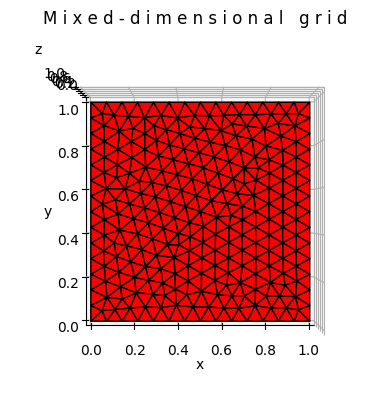

In [11]:
model = SinglePhaseFlowWithGeometry()
model.prepare_simulation()

# This is our geometry:
pp.plot_grid(model.mdg)

What happenes inside `model.prepare_simulation`?

In [12]:
print(inspect.getsource(model.prepare_simulation))

    def prepare_simulation(self) -> None:
        """Run at the start of simulation. Used for initialization etc."""
        # Set the geometry of the problem. This is a method that must be implemented
        # in a ModelGeometry class.
        self.set_geometry()

        # Exporter initialization must be done after grid creation,
        # but prior to data initialization.
        self.initialize_data_saving()

        # Set variables, constitutive relations, discretizations and equations.
        # Order of operations is important here.
        self.set_equation_system_manager()
        self.set_materials()
        self.create_variables()
        self.initial_condition()
        self.reset_state_from_file()
        self.set_equations()

        self.set_discretization_parameters()
        self.discretize()
        self._initialize_linear_solver()
        self.set_nonlinear_discretizations()

        # Export initial condition
        self.save_data_time_step()



The `prepare_simulation` method runs a sequence of initialization steps, all of which 
are important. However, we will focus on two steps for now:

- Initializing the independent variables of the simulation in the `create_variables` 
method. In our case, these are pressure $P$ and interface fluxe.
- Initializing the equations of the model in the `set_equations` method. In our case, 
these are the mass balance equation and the interface equations.

The bookkeeping of variables and equations is done with the `equation_system` attribute 
of the model:

In [13]:
model.equation_system

EquationSystem for mixed-dimensional grid with 2 subdomains and 1 interfaces.
Variables present on at least one grid or interface:
	pressure, interface_darcy_flux
In total 3 equations, with names: 
	mass_balance_equation, interface_darcy_flux_equation, well_flux_equation

# Variables creation
The variables are created in the method `create_variables`. Inside this method, we register all the model variables to the `equation_system`:

In [14]:
print(inspect.getsource(model.create_variables))

    def create_variables(self) -> None:
        """Assign primary variables to subdomains and interfaces of the
        mixed-dimensional grid.

        """
        self.equation_system.create_variables(
            self.pressure_variable,
            subdomains=self.mdg.subdomains(),
            tags={"si_units": "Pa"},
        )
        # Note that `interface_darcy_flux_variable` is not multiplied by rho * mu^-1.
        # However, after multiplication, whe know that the resulting flux should be a
        # mass flux with units  `kg * s^-1`. The units of `interface_darcy_flux` can
        # then be inferred by solving the below equation for `int_flux_units`:
        # kg * s^-1 = [kg * (m^nd)^-1] * [Pa * s]^-1 * intf_flux_units
        self.equation_system.create_variables(
            self.interface_darcy_flux_variable,
            interfaces=self.mdg.interfaces(codim=1),
            tags={"si_units": f"m^{self.nd} * Pa"},
        )
        self.equation_system.create_variables(
   

It is a good practice to store the variable names in the attributes of the model:

In [16]:
model.pressure_variable

'pressure'

We can access a variable from the outside by its name:

In [17]:
p = model.equation_system.md_variable(model.pressure_variable)
p

Mixed-dimensional variable with name pressure, id 28
Composed of 2 variables
Total size: 488

The variable is an abstract AD object that does not store the values. It is used to 
define equations to be evaluated later. However, the model stores the current state of 
the values for our variables, and we can access them using the evaluate method.

<ul><em>
<b>Note for an advanced reader:</b> 

The variable object incorporates the variables on all the grids in the mixed-dimensional
setting. This means, we can operate with one object and simultainously define an 
equation on all the grids.
Here, we will define an equation both on 1D and 2D grids.
</em></ul>



In [18]:
p_initial = p.evaluate(model.equation_system).val
p_initial[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Since nothing has happened in the simulation yet, it returns the initial condition, which has been set in the `initial_condition` method - one more method inside `prepare_simulation`.

We can change this state manually by calling the `set_variable_values` method on the `equation_system`:

In [19]:
import numpy as np

p_new = np.sin(np.arange(p_initial.size))

model.equation_system.set_variable_values(
    values=p_new,
    variables=[p],
    iterate_index=0,  #   | For a more advanced reader:
    time_step_index=0,  # | We reference the nonlinear solver code to see what these
    additive=False,  #    | keyword arguments do.
)

# Check that it worked
p.evaluate(model.equation_system).val[:10]

array([ 0.        ,  0.84147098,  0.90929743,  0.14112001, -0.7568025 ,
       -0.95892427, -0.2794155 ,  0.6569866 ,  0.98935825,  0.41211849])

# Setting equations
To set the equations in the model, we use the `set_equation` method inside `prepare_simulation`. This method can be a bit complicated, so we will start with a simplified example to make it easier to understand.

To create an equation, we apply arithmetic operators to variables. For example, we will define a polynomial equation:

In [20]:
poly_eq = p**2 + p * 5 + 2

The equation is also an AD object, just like the variable. It also has the `evaluate` method.
When we run it, the values of pressure are substituted:

In [21]:
poly_eq_result = poly_eq.evaluate(model.equation_system)
poly_eq_result

Ad array of size 488
Jacobian is of size (488, 512) and has 488 elements

It returns the AD array, just like we saw in the beginning of this tutorial. We can access the values:

In [22]:
poly_eq_result.val[:10]

array([ 2.        ,  6.91542834,  7.37330894,  2.7255149 , -1.21126246,
       -1.87508561,  0.68099553,  5.71656438,  7.92562097,  4.23043407])

The Jacobian $\frac{\partial F}{\partial p}$ is accessible automatically:

In [23]:
poly_eq_result.jac.todense()[:10, :5]

matrix([[5.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 6.68294197, 0.        , 0.        , 0.        ],
        [0.        , 0.        , 6.81859485, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 5.28224002, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 3.48639501],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ]])

<ul><em>
<b>Note for an advanced reader:</b> 

In order to make our equation a full-fledged PDE, we must discretize spatial derivatives. 
This is a more advanced topic, so we reference you to look at the source code of models to see how it is implemented.
</em></ul>

The `set_equations` method is where equations are defined in the model, just as we did here with our polynomial equation.
For convenience, separate parts of an equation are defined in separate functions. These functions are called separately, so that we assemble an equation from smaller blocks.

As an example, let's look at the mass balance equation. This equation is typically defined using the accumulation, flux and source terms. These functions can be called separately to assemble each term, and then combined to create the full mass balance equation.

In [24]:
print(inspect.getsource(model.mass_balance_equation))

    def mass_balance_equation(self, subdomains: list[pp.Grid]) -> pp.ad.Operator:
        """Mass balance equation for subdomains.

        Parameters:
            subdomains: List of subdomains.

        Returns:
            Operator representing the mass balance equation.

        """
        # Assemble the terms of the mass balance equation.
        accumulation = self.fluid_mass(subdomains)
        flux = self.fluid_flux(subdomains)
        source = self.fluid_source(subdomains)

        # Feed the terms to the general balance equation method.
        eq = self.balance_equation(subdomains, accumulation, flux, source, dim=1)
        eq.set_name("mass_balance_equation")
        return eq



For example, we will access the flux term separately:

In [25]:
subdomains = model.mdg.subdomains()
fluid_flux = model.fluid_flux(subdomains)
fluid_flux

Operator 'fluid_flux' formed by Operations.sub with 2 children.

We can evaluate separate parts of the Jacobian:

In [26]:
fluid_flux_data = fluid_flux.evaluate(model.equation_system)
fluid_flux_data

Ad array of size 767
Jacobian is of size (767, 512) and has 6731 elements

As you can see from the source code, we use the method `balance_equation` to define 
a conservation law:

In [32]:
accumulation = model.fluid_mass(subdomains)
flux = model.fluid_flux(subdomains)
source = model.fluid_source(subdomains)

eq = model.balance_equation(
    subdomains=subdomains,
    accumulation=accumulation,
    surface_term=flux,
    source=source,
    dim=1,  # Scalar equation
)

print(inspect.getsource(model.balance_equation))

    def balance_equation(
        self,
        subdomains: list[pp.Grid],
        accumulation: pp.ad.Operator,
        surface_term: pp.ad.Operator,
        source: pp.ad.Operator,
        dim: int,
    ) -> pp.ad.Operator:
        """Balance equation that combines an accumulation and a surface term.

        The balance equation is given by
        .. math::
            d_t(accumulation) + div(surface_term) - source = 0.

        Parameters:
            subdomains: List of subdomains where the balance equation is defined.
            accumulation: Operator for the cell-wise accumulation term, integrated over
                the cells of the subdomains.
            surface_term: Operator for the surface term (e.g. flux, stress), integrated
                over the faces of the subdomains.
            source: Operator for the source term, integrated over the cells of the
                subdomains.
            dim: Spatial dimension of the balance equation.

        Returns:
         

The complete equation is registred in the `equation_system`:

In [24]:
print(inspect.getsource(model.set_equations))

    def set_equations(self):
        """Set the equations for the mass balance problem.

        A mass balance equation is set for all subdomains and a Darcy-type flux relation
        is set for all interfaces of codimension one.

        """
        subdomains = self.mdg.subdomains()
        codim_1_interfaces = self.mdg.interfaces(codim=1)
        # TODO: If wells are integrated for nd=2 models, consider refactoring sorting of
        # interfaces into method returning either "normal" or well interfaces.
        codim_2_interfaces = self.mdg.interfaces(codim=2)
        sd_eq = self.mass_balance_equation(subdomains)
        intf_eq = self.interface_darcy_flux_equation(codim_1_interfaces)
        well_eq = self.well_flux_equation(codim_2_interfaces)
        self.equation_system.set_equation(sd_eq, subdomains, {"cells": 1})
        self.equation_system.set_equation(intf_eq, codim_1_interfaces, {"cells": 1})
        self.equation_system.set_equation(well_eq, codim_2_interfaces, {"cells

Now we are ready to run the simulation. During the simulatiom, the values of the variables will update, and the AD equations will automaticaly produce the Jacobian based on the new values.

The full Jacobian and the values of the equations can be accessed through the `equation_system`:

In [33]:
jacobian, vals = model.equation_system.assemble()

In [34]:
vals[:10]

array([-0.24652838, -1.0103203 , -4.92540505,  0.465926  ,  1.23307361,
        4.41870697,  0.86485525, -0.76625288, -2.59187967,  0.58076449])

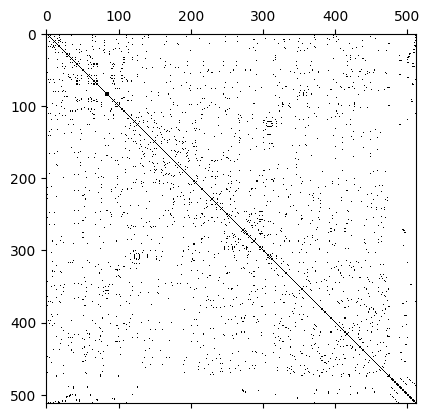

In [35]:
plt.spy(jacobian.toarray())

# What have we done
We have looked at the AD framework and how it is utilized by the PorePy models.

Key messages:
- The AD framework is capable of computing the Jacobian of an equation automatically. 
- In PorePy model, the AD objects are prepared in the `prepare_simulation` method.
- The variables are defined in the `create_variables` method.
- The equations are assembled from the variables in the `set_equations` method.
- The process of assembling an equation is modular. You can access separate terms of an equation by calling the model methods. 
- The equations can be evaluated many times with the new values of the variables, and the Jacobian will be computed automatically.


#